In [ ]:
!pip install matplotlib

In [ ]:
!pip install seaborn

In [ ]:
!pip install tensorflow

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install spotipy

In [72]:
import pandas as pd
import numpy as np
import glob
import os
from os import listdir
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pickle
import joblib
from joblib import dump, load

import tensorflow as tf
import sklearn 
from sklearn.utils import shuffle
from tensorflow import keras
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Model, Sequential, save_model, load_model
from tensorflow.config import list_logical_devices
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [10]:
# Spotipy user config

client_id="468661e92a884784968d2bec32d8dd09"
client_secret="9751a57846e442ea85fc1db2218fcf35"

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret))

In [11]:
def get_decade(year):
    """
    Get quantity of songs released per decade 
    """
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    
    return decade

In [14]:
def wrangle():
    """
    wrangling function to load dataset, clean text & create additional features
    """
    # read in just the US spotify dataset
    df = pd.read_csv("C:\\Users\\trewq\\OneDrive\\Documents\\Lambda\\Unit 4\\buildweek\\spotifysuggestor\\files\\us.csv")
    
    # General House Keeping--clean the artist and artist_id text
    df['artists'] = df['artists'].str.strip('['']')
    df['artists'] = df['artists'].str.strip('""')
    df['artists'] = df['artists'].str.replace("'", "")

    df['id_artists'] = df['id_artists'].str.strip('['']')
    df['id_artists'] = df['id_artists'].str.strip('""')
    df['id_artists'] = df['id_artists'].str.replace("'", "")

    # create combined feature (song name - artist)
    df['combined'] = df['name'] + ' - ' + df['artists']
    
    # create decades feature for graphing
    df['year'] = pd.DatetimeIndex(df['release_date']).year
    df['decade'] = df['year'].apply(get_decade)
    
    # combine url and id for song to query results using Spotipy
    url = 'http://open.spotify.com/track/' + df['id']
    df['url'] = url

    return df

In [15]:
df = wrangle()

In [16]:
df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade,url
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,Uli,45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.4450,...,0.674,0.7440,0.151,0.127,104.851,3,Carve - Uli,1922,1920s,http://open.spotify.com/track/35iwgR4jXetI318W...
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,Fernando Pessoa,14jtPCOoNZwquk5wd9DxrY,1922-06-01,0.695,0.2630,...,0.797,0.0000,0.148,0.655,102.009,1,Capítulo 2.16 - Banquero Anarquista - Fernando...,1922,1920s,http://open.spotify.com/track/021ht4sdgPcrDgSk...
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.434,0.1770,...,0.994,0.0218,0.212,0.457,130.418,5,Vivo para Quererte - Remasterizado - Ignacio C...,1922,1920s,http://open.spotify.com/track/07A5yehtSnoedViJ...
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.321,0.0946,...,0.995,0.9180,0.104,0.397,169.980,3,El Prisionero - Remasterizado - Ignacio Corsini,1922,1920s,http://open.spotify.com/track/08FmqUhxtyLTn6pA...
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,Dick Haymes,3BiJGZsyX9sJchTqcSA7Su,1922,0.402,0.1580,...,0.989,0.1300,0.311,0.196,103.220,4,Lady of the Evening - Dick Haymes,1922,1920s,http://open.spotify.com/track/08y9GfoqCWfOGsKd...


In [17]:
# this will show rows that are 100% equal to other rows. 
df.duplicated().value_counts()

False    93135
dtype: int64

In [18]:
# it was considered to drop duplicated names however after further review there 
# are some songs named the same thing from different artists. Also there are a few cases where songs 
# from the same artist with the same name have almost identical features but are not 100% identical
# It is difficult to know if this is erroneous information or if they are merely different versions
# of the same song ex. acoustic version, live version, concert version etc. 

df.duplicated(subset=['name']).value_counts()

False    77927
True     15208
dtype: int64

In [19]:
df.shape

(93135, 24)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93135 entries, 0 to 93134
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                93135 non-null  object 
 1   name              93135 non-null  object 
 2   popularity        93135 non-null  int64  
 3   duration_ms       93135 non-null  int64  
 4   explicit          93135 non-null  int64  
 5   artists           93135 non-null  object 
 6   id_artists        93135 non-null  object 
 7   release_date      93135 non-null  object 
 8   danceability      93135 non-null  float64
 9   energy            93135 non-null  float64
 10  key               93135 non-null  int64  
 11  loudness          93135 non-null  float64
 12  mode              93135 non-null  int64  
 13  speechiness       93135 non-null  float64
 14  acousticness      93135 non-null  float64
 15  instrumentalness  93135 non-null  float64
 16  liveness          93135 non-null  float6

In [21]:
df.nunique()

id                  93135
name                77927
popularity            101
duration_ms         38215
explicit                2
artists             21582
id_artists          21617
release_date         8442
danceability         1120
energy               2095
key                    12
loudness            22419
mode                    2
speechiness          1544
acousticness         4545
instrumentalness     5381
liveness             1714
valence              1642
tempo               59630
time_signature          5
combined            87509
year                  100
decade                 11
url                 93135
dtype: int64

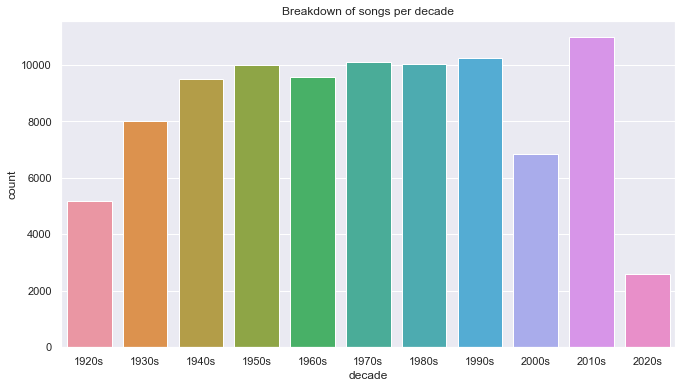

In [27]:
# Breakdown of songs per decade

plt.title('Breakdown of songs per decade')
sns.set(rc={'figure.figsize':(11 ,6)})
sns.countplot(df['decade'].sort_values())
plt.show()

In [28]:
#top artist by popularity of songs

df.groupby("artists")["popularity"].sum().sort_values(ascending=False).head(20)

artists
The Beatles                 17479
Frank Sinatra               12864
The Rolling Stones          11913
Taylor Swift                11480
Fleetwood Mac               10994
Elvis Presley               10928
Led Zeppelin                10596
Bob Marley & The Wailers     9684
Pink Floyd                   9141
David Bowie                  8039
Queen                        7800
The Beach Boys               7644
Billie Holiday               7565
Johnny Cash                  7454
Bob Dylan                    7375
Dean Martin                  6708
Vicente Fernández            6401
Billy Joel                   6388
Metallica                    5933
AC/DC                        5892
Name: popularity, dtype: int64

**------------------------------Predictions------------------------------------**


In [29]:
# segment numerical features and save in DataFrame
data = df.select_dtypes('number')
data.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,6,126903,0,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,1922
1,0,98200,0,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,1922
2,0,181640,0,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,1922
3,0,176907,0,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,1922
4,0,163080,0,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,1922


In [30]:
def normalize_column(col):
    """
    function to normalize data in numerical features
    """
    max_d = data[col].max()
    min_d = data[col].min()
    data[col] = (data[col] - min_d)/(max_d - min_d)
    
num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = data.select_dtypes(include=num_types)
        
for col in num.columns:
    normalize_column(col)
    

In [31]:
# DataFrame with only numerical features
data.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,0.06,0.025400,0.0,0.652834,0.4450,0.000000,0.730749,1.0,0.464948,0.676707,0.7440,0.151151,0.127,0.430826,0.6,0.0
1,0.00,0.019414,0.0,0.703441,0.2630,0.000000,0.592968,1.0,0.986598,0.800201,0.0000,0.148148,0.655,0.419148,0.2,0.0
2,0.00,0.036816,0.0,0.439271,0.1770,0.090909,0.607940,1.0,0.052784,0.997992,0.0218,0.212212,0.457,0.535879,1.0,0.0
3,0.00,0.035829,0.0,0.324899,0.0946,0.636364,0.501746,1.0,0.051959,0.998996,0.9180,0.104104,0.397,0.698437,0.6,0.0
4,0.00,0.032945,0.0,0.406883,0.1580,0.272727,0.674967,0.0,0.040206,0.992972,0.1300,0.311311,0.196,0.424124,0.8,0.0


In [32]:
# drop year feature--doesn't seem very informative
data = data.drop(columns=['year'])

In [33]:
data.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0.06,0.025400,0.0,0.652834,0.4450,0.000000,0.730749,1.0,0.464948,0.676707,0.7440,0.151151,0.127,0.430826,0.6
1,0.00,0.019414,0.0,0.703441,0.2630,0.000000,0.592968,1.0,0.986598,0.800201,0.0000,0.148148,0.655,0.419148,0.2
2,0.00,0.036816,0.0,0.439271,0.1770,0.090909,0.607940,1.0,0.052784,0.997992,0.0218,0.212212,0.457,0.535879,1.0
3,0.00,0.035829,0.0,0.324899,0.0946,0.636364,0.501746,1.0,0.051959,0.998996,0.9180,0.104104,0.397,0.698437,0.6
4,0.00,0.032945,0.0,0.406883,0.1580,0.272727,0.674967,0.0,0.040206,0.992972,0.1300,0.311311,0.196,0.424124,0.8


In [34]:
data.columns

Index(['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

In [35]:
data = data.to_numpy()

In [36]:
number_features = data.shape[1]
number_features

15

In [37]:
# Tensorflow subclass API

class AutoEncoder(Model):
    def __init__(self):
        #Inherit init from Model base class
        super(AutoEncoder, self).__init__()

        # Encoder portion utilizing Keras Sequential
        self.encoder = Sequential([
            Dense(256, input_shape=(data.shape[1],), activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(8, activation='elu')])
        # Encoder portion utilizing Keras Sequential
        self.decoder = Sequential([
            Dense(64, activation='elu'),
            Dense(128, activation='relu'),
            Dense(256, activation='relu'),
            Dense(number_features, activation='relu')])

    # This function is used by fit to pass data through both the encoder and decoder
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [38]:
# instantiate & compile the model
model = AutoEncoder()
model.compile(optimizer = 'rmsprop', loss = 'mae')

In [39]:
# fit the model

stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)

model.fit(data, data, 
          shuffle=True, epochs=100, 
          batch_size=16,
          callbacks = stop,
          workers=10, use_multiprocessing=True, 
          validation_split=.1)

Epoch 1/100
5239/5239 [==============================] - 11s 2ms/step - loss: 0.0666 - val_loss: 0.0618
Epoch 2/100
5239/5239 [==============================] - 11s 2ms/step - loss: 0.0449 - val_loss: 0.0557
Epoch 3/100
5239/5239 [==============================] - 10s 2ms/step - loss: 0.0389 - val_loss: 0.0543
Epoch 4/100
5239/5239 [==============================] - 10s 2ms/step - loss: 0.0371 - val_loss: 0.0470
Epoch 5/100
5239/5239 [==============================] - 10s 2ms/step - loss: 0.0359 - val_loss: 0.0473
Epoch 6/100
5239/5239 [==============================] - 10s 2ms/step - loss: 0.0350 - val_loss: 0.0459
Epoch 7/100
5239/5239 [==============================] - 10s 2ms/step - loss: 0.0343 - val_loss: 0.0446
Epoch 8/100
5239/5239 [==============================] - 10s 2ms/step - loss: 0.0337 - val_loss: 0.0482
Epoch 9/100
5239/5239 [==============================] - 10s 2ms/step - loss: 0.0332 - val_loss: 0.0500
Epoch 10/100
5239/5239 [==============================] - 10s 2m

In [40]:
encoded_data = model.encoder(data)

In [41]:
# nearest neighbors 
knn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', radius=1, n_jobs=-1)
knn.fit(encoded_data)


NearestNeighbors(algorithm='ball_tree', n_jobs=-1, radius=1)

In [42]:
# choose a random element from a list
# using this to set up random queries using knn results

from random import seed
from random import choice


# prepare a sequence
sequence = [i for i in range(93136)]

# make choices from the sequence
for _ in range(1):
    selection = choice(sequence)
    print(selection)

64369


In [43]:
query = selection

_, ind = knn.kneighbors([encoded_data[query]])

print(selection)

64369


In [44]:
df.iloc[ind[0]]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade,url
64369,3k5ycyXX5qsCjLd7R2vphp,Mona Lisa,43,207573,0,Nat King Cole,7v4imS0moSyGdXyLgVTIV7,1991-01-01,0.214,0.194,...,0.903,0.000001,0.107,0.339,86.198,3,Mona Lisa - Nat King Cole,1991,1990s,http://open.spotify.com/track/3k5ycyXX5qsCjLd7...
35127,5W3LUZBuSAMS0jnVaPsiaA,There's No Tomorrow - Remastered,29,168093,0,Dean Martin,49e4v89VmlDcFCMyDv9wQ9,1962-02-05,0.203,0.214,...,0.895,0.021200,0.109,0.283,83.437,4,There's No Tomorrow - Remastered - Dean Martin,1962,1960s,http://open.spotify.com/track/5W3LUZBuSAMS0jnV...
33793,06zMm73RxNxnGxtwZWFP6K,Blue Hawaii,44,156187,0,Elvis Presley,43ZHCT0cAZBISjO8DG9PnE,1961-10-20,0.252,0.281,...,0.958,0.000241,0.193,0.365,82.107,4,Blue Hawaii - Elvis Presley,1961,1960s,http://open.spotify.com/track/06zMm73RxNxnGxtw...
29914,6G7QhTqDsP5vIdLQTYXXOU,The Christmas Waltz - Remastered,35,181773,0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,1957-09,0.233,0.139,...,0.898,0.000000,0.116,0.242,79.948,4,The Christmas Waltz - Remastered - Frank Sinatra,1957,1950s,http://open.spotify.com/track/6G7QhTqDsP5vIdLQ...
45372,6WRv0Mr5Y2K3qG5qraEPiA,He Touched Me,37,158627,0,Elvis Presley,43ZHCT0cAZBISjO8DG9PnE,1972-04-03,0.228,0.245,...,0.918,0.001950,0.131,0.295,82.962,4,He Touched Me - Elvis Presley,1972,1970s,http://open.spotify.com/track/6WRv0Mr5Y2K3qG5q...


**---------------------------LeakyRelu Model------------------------------**

In [45]:
data.shape[1]

15

In [46]:
data.shape[1:]

(15,)

In [47]:
# LeakyRelu Autoencoder
class AutoEncoderLeaky(Model):
    def __init__(self, alpha):
        super(AutoEncoderLeaky, self).__init__()

        self.encoder = Sequential([
            Dense(128, input_shape=data.shape[1:]),
            LeakyReLU(alpha),
            Dense(64),
            LeakyReLU(alpha),
            Dense(32),
            LeakyReLU(alpha),
            Dense(8),
            LeakyReLU(alpha)])

        self.decoder = Sequential([
            Dense(32),
            LeakyReLU(alpha),
            Dense(64),
            LeakyReLU(alpha),
            Dense(128),
            LeakyReLU(alpha),
            Dense(number_features),
            LeakyReLU(alpha)])
    

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [48]:
# set alpha rate for LeakyRelu 
model_leaky = AutoEncoderLeaky(0.1)
model_leaky.compile(optimizer='rmsprop', loss='mae')

In [50]:
# fit the model

stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)

model_leaky.fit(data, data, 
                shuffle=True, epochs=100, 
                batch_size=16,
                callbacks = stop,
                workers=10, use_multiprocessing=True, 
                validation_split=.1)

Epoch 1/100
5239/5239 [==============================] - 9s 2ms/step - loss: 0.0599 - val_loss: 0.0583
Epoch 2/100
5239/5239 [==============================] - 8s 2ms/step - loss: 0.0400 - val_loss: 0.0412
Epoch 3/100
5239/5239 [==============================] - 8s 2ms/step - loss: 0.0347 - val_loss: 0.0439
Epoch 4/100
5239/5239 [==============================] - 8s 2ms/step - loss: 0.0320 - val_loss: 0.0352
Epoch 5/100
5239/5239 [==============================] - 8s 2ms/step - loss: 0.0275 - val_loss: 0.0319
Epoch 6/100
5239/5239 [==============================] - 8s 2ms/step - loss: 0.0254 - val_loss: 0.0314
Epoch 7/100
5239/5239 [==============================] - 8s 2ms/step - loss: 0.0244 - val_loss: 0.0274
Epoch 8/100
5239/5239 [==============================] - 8s 2ms/step - loss: 0.0237 - val_loss: 0.0282
Epoch 9/100
5239/5239 [==============================] - 8s 2ms/step - loss: 0.0231 - val_loss: 0.0279
Epoch 10/100
5239/5239 [==============================] - 8s 2ms/step - l

In [51]:
encoded_data_leaky = model_leaky.encoder(data)

In [52]:
# nearest neighbors 
knn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', radius=1, n_jobs=-1)
knn.fit(encoded_data_leaky)

NearestNeighbors(algorithm='ball_tree', n_jobs=-1, radius=1)

In [53]:
# query the data for knn 
query = selection

_, ind_leaky = knn.kneighbors([encoded_data_leaky[query]])

#print(selection)

In [54]:
# output LeakyRelu Model
df.iloc[ind_leaky[0]]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade,url
64369,3k5ycyXX5qsCjLd7R2vphp,Mona Lisa,43,207573,0,Nat King Cole,7v4imS0moSyGdXyLgVTIV7,1991-01-01,0.214,0.194,...,0.903,0.000001,0.107,0.339,86.198,3,Mona Lisa - Nat King Cole,1991,1990s,http://open.spotify.com/track/3k5ycyXX5qsCjLd7...
35127,5W3LUZBuSAMS0jnVaPsiaA,There's No Tomorrow - Remastered,29,168093,0,Dean Martin,49e4v89VmlDcFCMyDv9wQ9,1962-02-05,0.203,0.214,...,0.895,0.021200,0.109,0.283,83.437,4,There's No Tomorrow - Remastered - Dean Martin,1962,1960s,http://open.spotify.com/track/5W3LUZBuSAMS0jnV...
29914,6G7QhTqDsP5vIdLQTYXXOU,The Christmas Waltz - Remastered,35,181773,0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,1957-09,0.233,0.139,...,0.898,0.000000,0.116,0.242,79.948,4,The Christmas Waltz - Remastered - Frank Sinatra,1957,1950s,http://open.spotify.com/track/6G7QhTqDsP5vIdLQ...
28872,3o4kEG4w3grr36bWyeZxK0,Luna Rossa,33,184893,0,Jerry Vale,5MaJrqhwysKwbvDePyAS6l,1956,0.292,0.191,...,0.912,0.000002,0.095,0.229,86.171,3,Luna Rossa - Jerry Vale,1956,1950s,http://open.spotify.com/track/3o4kEG4w3grr36bW...
20735,5Wy5kMFCFpVGkIsASUB5jI,Till We Meet Again,32,156667,0,Doris Day,3ESG6pj6a0LvUKklENalT6,1948,0.183,0.113,...,0.954,0.000039,0.104,0.182,85.134,4,Till We Meet Again - Doris Day,1948,1940s,http://open.spotify.com/track/5Wy5kMFCFpVGkIsA...


In [55]:
# query from 1st model above- shown for comparison of query results
df.iloc[ind[0]]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade,url
64369,3k5ycyXX5qsCjLd7R2vphp,Mona Lisa,43,207573,0,Nat King Cole,7v4imS0moSyGdXyLgVTIV7,1991-01-01,0.214,0.194,...,0.903,0.000001,0.107,0.339,86.198,3,Mona Lisa - Nat King Cole,1991,1990s,http://open.spotify.com/track/3k5ycyXX5qsCjLd7...
35127,5W3LUZBuSAMS0jnVaPsiaA,There's No Tomorrow - Remastered,29,168093,0,Dean Martin,49e4v89VmlDcFCMyDv9wQ9,1962-02-05,0.203,0.214,...,0.895,0.021200,0.109,0.283,83.437,4,There's No Tomorrow - Remastered - Dean Martin,1962,1960s,http://open.spotify.com/track/5W3LUZBuSAMS0jnV...
33793,06zMm73RxNxnGxtwZWFP6K,Blue Hawaii,44,156187,0,Elvis Presley,43ZHCT0cAZBISjO8DG9PnE,1961-10-20,0.252,0.281,...,0.958,0.000241,0.193,0.365,82.107,4,Blue Hawaii - Elvis Presley,1961,1960s,http://open.spotify.com/track/06zMm73RxNxnGxtw...
29914,6G7QhTqDsP5vIdLQTYXXOU,The Christmas Waltz - Remastered,35,181773,0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,1957-09,0.233,0.139,...,0.898,0.000000,0.116,0.242,79.948,4,The Christmas Waltz - Remastered - Frank Sinatra,1957,1950s,http://open.spotify.com/track/6G7QhTqDsP5vIdLQ...
45372,6WRv0Mr5Y2K3qG5qraEPiA,He Touched Me,37,158627,0,Elvis Presley,43ZHCT0cAZBISjO8DG9PnE,1972-04-03,0.228,0.245,...,0.918,0.001950,0.131,0.295,82.962,4,He Touched Me - Elvis Presley,1972,1970s,http://open.spotify.com/track/6WRv0Mr5Y2K3qG5q...


**Query songs based off of User preference imputs--Song name & artist**

In [56]:
# test finding a song to use as an input to recommender, returns index position
song = df[df['combined'] == 'Get Down - Nas'].sort_values('popularity', ascending=False)
song

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade,url
75207,3UYuDTslR35thjQzaVwRMe,Get Down,61,244253,1,Nas,20qISvAhX20dpIbOOzGK3q,2002-12-13,0.835,0.718,...,0.0424,0.0,0.258,0.507,94.387,4,Get Down - Nas,2002,2000s,http://open.spotify.com/track/3UYuDTslR35thjQz...


In [57]:
song.index[0]

75207

In [58]:
encoded_data_leaky = model_leaky.encoder(data)
# nearest neighbors 
knn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', radius=1, n_jobs=-1)
knn.fit(encoded_data_leaky)

NearestNeighbors(algorithm='ball_tree', n_jobs=-1, radius=1)

In [59]:
# query the data for knn 
query = song.index[0]

_, ind_leaky = knn.kneighbors([encoded_data_leaky[query]])

In [60]:
# output LeakyRelu Model
df.iloc[ind_leaky[0]]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade,url
75207,3UYuDTslR35thjQzaVwRMe,Get Down,61,244253,1,Nas,20qISvAhX20dpIbOOzGK3q,2002-12-13,0.835,0.718,...,0.04240,0.000000,0.258,0.507,94.387,4,Get Down - Nas,2002,2000s,http://open.spotify.com/track/3UYuDTslR35thjQz...
70039,1Zc9TBoPG8U5epucXYcEFa,What Is A Juggalo?,49,237600,1,Insane Clown Posse,4xtWjIlVuZwTCeqVAsgEXy,1997-01-01,0.726,0.721,...,0.00731,0.000006,0.244,0.475,174.118,4,What Is A Juggalo? - Insane Clown Posse,1997,1990s,http://open.spotify.com/track/1Zc9TBoPG8U5epuc...
70771,7xXy5wG7nUXwCz6zrnwiTI,Intro,64,249933,1,DMX,1HwM5zlC5qNWhJtM00yXzG,1998-05-01,0.710,0.714,...,0.00619,0.000071,0.245,0.355,103.560,4,Intro - DMX,1998,1990s,http://open.spotify.com/track/7xXy5wG7nUXwCz6z...
92881,3pGRj6u9DCE9PQips45eJ1,None of Your Love - Bonus,67,153168,1,Lil Tjay,6jGMq4yGs7aQzuGsMgVgZR,2021-04-02,0.702,0.722,...,0.01990,0.000000,0.299,0.510,137.963,4,None of Your Love - Bonus - Lil Tjay,2021,2020s,http://open.spotify.com/track/3pGRj6u9DCE9PQip...
77443,24PWKmemCvqfyVXODhoKHW,Sittin' Sidewayz (feat. Big Pokey),61,228933,1,"Paul Wall, Big Pokey","0k7Xl1pqI3tu8sSEjo5oEg, 1J6iGa2TNBDCrJzjsnI1a8",2005-07-19,0.721,0.621,...,0.00469,0.010300,0.199,0.568,159.967,4,Sittin' Sidewayz (feat. Big Pokey) - Paul Wall...,2005,2000s,http://open.spotify.com/track/24PWKmemCvqfyVXO...


In [61]:
# take NearestNeighbor vector results and place in list
nn_song_index = ind_leaky.flat[:].tolist()
nn_song_index

[75207, 70039, 70771, 92881, 77443]

In [62]:
# configure nn_song_index Nearest Neighbor result output
mask = ['combined', 'url']
df_result = df[mask]
df_result.iloc[nn_song_index]

,combined,url
75207,Get Down - Nas,http://open.spotify.com/track/3UYuDTslR35thjQz...
70039,What Is A Juggalo? - Insane Clown Posse,http://open.spotify.com/track/1Zc9TBoPG8U5epuc...
70771,Intro - DMX,http://open.spotify.com/track/7xXy5wG7nUXwCz6z...
92881,None of Your Love - Bonus - Lil Tjay,http://open.spotify.com/track/3pGRj6u9DCE9PQip...
77443,Sittin' Sidewayz (feat. Big Pokey) - Paul Wall...,http://open.spotify.com/track/24PWKmemCvqfyVXO...


**Query songs based off of user preference inputs--Artist**

In [63]:
# list most popular songs by a given artist, return index position of most popular songs
artist = df[df['artists'] == 'Mos Def'].sort_values('popularity', ascending=False)
artist


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade,url
71755,0IVAlb0cFCH1cQ974iR1TU,Ms. Fat Booty,71,223547,1,Mos Def,0Mz5XE0kb1GBnbLQm2VbcO,1999-10-12,0.782,0.589,...,0.1480,0.0,0.1640,0.869,90.438,4,Ms. Fat Booty - Mos Def,1999,1990s,http://open.spotify.com/track/0IVAlb0cFCH1cQ97...
71848,3gRlmtdCyNoKiyozn2pqc9,Mathematics,62,246440,1,Mos Def,0Mz5XE0kb1GBnbLQm2VbcO,1999-10-12,0.753,0.749,...,0.0285,0.0,0.0845,0.832,93.790,4,Mathematics - Mos Def,1999,1990s,http://open.spotify.com/track/3gRlmtdCyNoKiyoz...
71893,5Ru9OjtEw5htfnVKpYsIcv,UMI Says,59,305280,1,Mos Def,0Mz5XE0kb1GBnbLQm2VbcO,1999-10-12,0.720,0.670,...,0.3050,0.0,0.0928,0.566,121.342,4,UMI Says - Mos Def,1999,1990s,http://open.spotify.com/track/5Ru9OjtEw5htfnVK...
72151,4gQdwwPXSXnDkUh4jYqLoC,Hip Hop,53,196440,1,Mos Def,0Mz5XE0kb1GBnbLQm2VbcO,1999-10-12,0.592,0.861,...,0.0240,0.0,0.4920,0.794,90.238,4,Hip Hop - Mos Def,1999,1990s,http://open.spotify.com/track/4gQdwwPXSXnDkUh4...
72597,5WwGFUPLWz6t7jROXn6j4M,Speed Law,46,256453,1,Mos Def,0Mz5XE0kb1GBnbLQm2VbcO,1999-10-12,0.795,0.667,...,0.0568,0.0,0.4070,0.694,98.024,4,Speed Law - Mos Def,1999,1990s,http://open.spotify.com/track/5WwGFUPLWz6t7jRO...


In [64]:
artist.index[0]

71755

In [65]:
encoded_data_leaky = model_leaky.encoder(data)
# nearest neighbors 
knn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', radius=1, n_jobs=-1)
knn.fit(encoded_data_leaky)

NearestNeighbors(algorithm='ball_tree', n_jobs=-1, radius=1)

In [66]:
# query the data for knn 
query = artist.index[0]

_, ind_leaky_artist = knn.kneighbors([encoded_data_leaky[query]])

In [67]:
# output LeakyRelu Model
df.iloc[ind_leaky_artist[0]]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade,url
71755,0IVAlb0cFCH1cQ974iR1TU,Ms. Fat Booty,71,223547,1,Mos Def,0Mz5XE0kb1GBnbLQm2VbcO,1999-10-12,0.782,0.589,...,0.1480,0.000000,0.1640,0.869,90.438,4,Ms. Fat Booty - Mos Def,1999,1990s,http://open.spotify.com/track/0IVAlb0cFCH1cQ97...
72809,7lgvU7WnwcNZ8dbGUz8yhP,Bitch Please II,70,288200,1,"Eminem, Dr. Dre, Snoop Dogg, Xzibit, Nate Dogg","7dGJo4pcD2V6oG8kP0tJRR, 6DPYiyq5kWVQS4RGwxzPC7...",2000-05-23,0.918,0.586,...,0.0783,0.000000,0.1450,0.779,95.517,4,"Bitch Please II - Eminem, Dr. Dre, Snoop Dogg,...",2000,2000s,http://open.spotify.com/track/7lgvU7WnwcNZ8dbG...
82488,2KBo6O5rkNdtYT3wYjkEkq,Fall In Love,64,235213,1,Slum Village,1020a42xVklY6c56imNcaa,2010-10-12,0.796,0.543,...,0.0486,0.005840,0.1240,0.784,91.212,4,Fall In Love - Slum Village,2010,2010s,http://open.spotify.com/track/2KBo6O5rkNdtYT3w...
89846,3EikYy40GMSp8l5mDV6IQo,Foot Fungus,79,129547,1,Ski Mask The Slump God,2rhFzFmezpnW82MNqEKVry,2018-11-30,0.881,0.623,...,0.2570,0.000002,0.0964,0.745,88.953,4,Foot Fungus - Ski Mask The Slump God,2018,2010s,http://open.spotify.com/track/3EikYy40GMSp8l5m...
92442,2aWVaW1p2kUc5yuKwBmRJi,I WANNA SEE SOME ASS (feat. jetsonmade),73,125302,1,"Jack Harlow, jetsonmade","2LIk90788K0zvyj2JJVwkJ, 0UcXjTpzt0DmIwPSNwlJfF",2020-03-13,0.899,0.691,...,0.1800,0.000451,0.1350,0.865,107.951,4,I WANNA SEE SOME ASS (feat. jetsonmade) - Jack...,2020,2020s,http://open.spotify.com/track/2aWVaW1p2kUc5yuK...


In [68]:
# take NearestNeighbor vector results and place in list
nn_artist_index = ind_leaky_artist.flat[:].tolist()
nn_artist_index

[71755, 72809, 82488, 89846, 92442]

In [69]:
# configure nn_artist_index Nearest Neighbor result output
mask = ['combined', 'url']
df_result = df[mask]
df_result.iloc[nn_artist_index]

,combined,url
71755,Ms. Fat Booty - Mos Def,http://open.spotify.com/track/0IVAlb0cFCH1cQ97...
72809,"Bitch Please II - Eminem, Dr. Dre, Snoop Dogg,...",http://open.spotify.com/track/7lgvU7WnwcNZ8dbG...
82488,Fall In Love - Slum Village,http://open.spotify.com/track/2KBo6O5rkNdtYT3w...
89846,Foot Fungus - Ski Mask The Slump God,http://open.spotify.com/track/3EikYy40GMSp8l5m...
92442,I WANNA SEE SOME ASS (feat. jetsonmade) - Jack...,http://open.spotify.com/track/2aWVaW1p2kUc5yuK...


**Save Model Architecture**

In [78]:
# save the model to disk
model.save("finalized_spotify_model")


INFO:tensorflow:Assets written to: finalized_spotify_model\assets


In [79]:
# reload model and test
modelRecon = keras.models.load_model("finalized_spotify_model")

In [90]:
encoded_data = modelRecon.encoder(data)

In [91]:
# nearest neighbors 
knn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', radius=1, n_jobs=-1)
knn.fit(encoded_data)

NearestNeighbors(algorithm='ball_tree', n_jobs=-1, radius=1)

In [92]:
# query the data for knn 
query = selection

_, ind_leaky = knn.kneighbors([encoded_data[query]])

#print(selection)

In [93]:
# output LeakyRelu Model
df.iloc[ind[0]]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade,url
64369,3k5ycyXX5qsCjLd7R2vphp,Mona Lisa,43,207573,0,Nat King Cole,7v4imS0moSyGdXyLgVTIV7,1991-01-01,0.214,0.194,...,0.903,0.000001,0.107,0.339,86.198,3,Mona Lisa - Nat King Cole,1991,1990s,http://open.spotify.com/track/3k5ycyXX5qsCjLd7...
35127,5W3LUZBuSAMS0jnVaPsiaA,There's No Tomorrow - Remastered,29,168093,0,Dean Martin,49e4v89VmlDcFCMyDv9wQ9,1962-02-05,0.203,0.214,...,0.895,0.021200,0.109,0.283,83.437,4,There's No Tomorrow - Remastered - Dean Martin,1962,1960s,http://open.spotify.com/track/5W3LUZBuSAMS0jnV...
33793,06zMm73RxNxnGxtwZWFP6K,Blue Hawaii,44,156187,0,Elvis Presley,43ZHCT0cAZBISjO8DG9PnE,1961-10-20,0.252,0.281,...,0.958,0.000241,0.193,0.365,82.107,4,Blue Hawaii - Elvis Presley,1961,1960s,http://open.spotify.com/track/06zMm73RxNxnGxtw...
29914,6G7QhTqDsP5vIdLQTYXXOU,The Christmas Waltz - Remastered,35,181773,0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,1957-09,0.233,0.139,...,0.898,0.000000,0.116,0.242,79.948,4,The Christmas Waltz - Remastered - Frank Sinatra,1957,1950s,http://open.spotify.com/track/6G7QhTqDsP5vIdLQ...
45372,6WRv0Mr5Y2K3qG5qraEPiA,He Touched Me,37,158627,0,Elvis Presley,43ZHCT0cAZBISjO8DG9PnE,1972-04-03,0.228,0.245,...,0.918,0.001950,0.131,0.295,82.962,4,He Touched Me - Elvis Presley,1972,1970s,http://open.spotify.com/track/6WRv0Mr5Y2K3qG5q...


**Save LeakRelu Architecture**

In [94]:
# save the LeakyRelu model to disk
model_leaky.save("finalized_spotify_model_leaky")


INFO:tensorflow:Assets written to: finalized_spotify_model_leaky\assets


In [100]:
# reload model and test
modelReconLeaky = keras.models.load_model("finalized_spotify_model_leaky")

In [101]:
encoded_data_leaky = modelReconLeaky.encoder(data)

In [102]:
# nearest neighbors 
knn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', radius=1, n_jobs=-1)
knn.fit(encoded_data_leaky)

NearestNeighbors(algorithm='ball_tree', n_jobs=-1, radius=1)

In [103]:
# query the data for knn 
query = selection

_, ind_leaky = knn.kneighbors([encoded_data_leaky[query]])

#print(selection)

In [104]:
# output LeakyRelu Model
df.iloc[ind_leaky[0]]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade,url
64369,3k5ycyXX5qsCjLd7R2vphp,Mona Lisa,43,207573,0,Nat King Cole,7v4imS0moSyGdXyLgVTIV7,1991-01-01,0.214,0.194,...,0.903,0.000001,0.107,0.339,86.198,3,Mona Lisa - Nat King Cole,1991,1990s,http://open.spotify.com/track/3k5ycyXX5qsCjLd7...
35127,5W3LUZBuSAMS0jnVaPsiaA,There's No Tomorrow - Remastered,29,168093,0,Dean Martin,49e4v89VmlDcFCMyDv9wQ9,1962-02-05,0.203,0.214,...,0.895,0.021200,0.109,0.283,83.437,4,There's No Tomorrow - Remastered - Dean Martin,1962,1960s,http://open.spotify.com/track/5W3LUZBuSAMS0jnV...
29914,6G7QhTqDsP5vIdLQTYXXOU,The Christmas Waltz - Remastered,35,181773,0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,1957-09,0.233,0.139,...,0.898,0.000000,0.116,0.242,79.948,4,The Christmas Waltz - Remastered - Frank Sinatra,1957,1950s,http://open.spotify.com/track/6G7QhTqDsP5vIdLQ...
28872,3o4kEG4w3grr36bWyeZxK0,Luna Rossa,33,184893,0,Jerry Vale,5MaJrqhwysKwbvDePyAS6l,1956,0.292,0.191,...,0.912,0.000002,0.095,0.229,86.171,3,Luna Rossa - Jerry Vale,1956,1950s,http://open.spotify.com/track/3o4kEG4w3grr36bW...
20735,5Wy5kMFCFpVGkIsASUB5jI,Till We Meet Again,32,156667,0,Doris Day,3ESG6pj6a0LvUKklENalT6,1948,0.183,0.113,...,0.954,0.000039,0.104,0.182,85.134,4,Till We Meet Again - Doris Day,1948,1940s,http://open.spotify.com/track/5Wy5kMFCFpVGkIsA...
